In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.optimize import minimize
import time
import talib as ta
from enum import Enum
import re
import os
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple, Any
from datetime import datetime, timedelta

import sys
import matplotlib.pyplot as plt
from scipy.stats import zscore, kurtosis, skew, yeojohnson, boxcox
from scipy.stats import tukeylambda, mstats
from sklearn.preprocessing import RobustScaler
import zipfile
from io import BytesIO

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute
from pathlib import Path


from gp_crypto_next import dataload, oi_dataload
from gp_crypto_next.dataload import DataFrequency

start_date = '2025-10-01'
end_date = '2025-11-01'
read_frequency = DataFrequency.MONTHLY

dir = '/Users/aming/data/ETHUSDT'
symbol = 'ETHUSDT'

date_range_list = dataload._generate_date_range(start_date=start_date, end_date=end_date, read_frequency=read_frequency)


In [2]:
oi_df_list = []

for date_str in date_range_list:
    df = pd.read_csv(f'{dir}/openInterest/openInterest_{date_str}.csv')
    oi_df_list.append(df)

oi_df = pd.concat(oi_df_list)

oi_df['open_time'] = pd.to_datetime(oi_df['open_time'])

oi_df.set_index('open_time', inplace=True)
oi_df.sort_index(inplace=True)
oi_df.drop(columns=['symbol'], inplace=True)


oi_df.head(10)


,openInterest
open_time,
2025-10-01 00:00:00.114,1827785.572
2025-10-01 00:00:05.408,1827799.596
2025-10-01 00:00:12.566,1827989.568
2025-10-01 00:00:20.574,1827917.962
2025-10-01 00:00:26.319,1827886.995
2025-10-01 00:00:34.273,1827852.958
2025-10-01 00:00:40.035,1827838.629
2025-10-01 00:00:43.411,1827845.617
2025-10-01 00:00:49.093,1827741.080


<Axes: xlabel='open_time'>

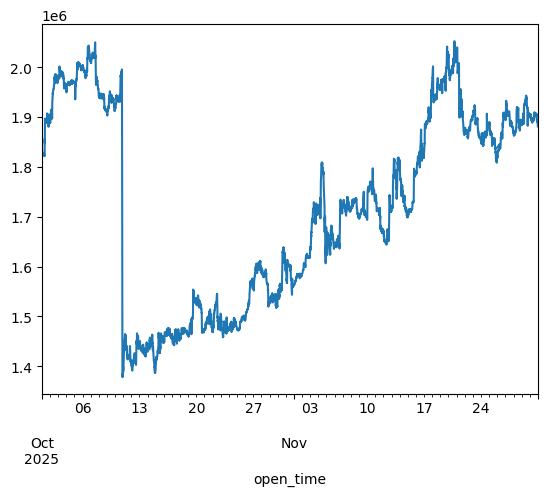

In [3]:
oi_df_resample = oi_df['openInterest'].resample('15min').ohlc()
    # 重命名防止混淆
oi_df_resample.columns = ['oi_open', 'oi_high', 'oi_low', 'oi_close']
oi_df_resample['oi_close'].plot()


处理多空数据
/Users/aming/data/ETHUSDT

takerlongshortRatio
topLongShortPositionRatio
topLongShortAccountRatio

大户的多头和空头总持仓量占比，大户指保证金余额排名前20%的用户。 
多仓持仓量比例 = 大户多仓持仓量 / 大户总持仓量 
空仓持仓量比例 = 大户空仓持仓量 / 大户总持仓量 
多空持仓量比值 = 多仓持仓量比例 / 空仓持仓量比例

topLongShortPositionRatio

https://developers.binance.com/docs/zh-CN/derivatives/usds-margined-futures/market-data/rest-api/Top-Trader-Long-Short-Ratio

{ 
         "symbol":"BTCUSDT",
	      "longShortRatio":"1.4342",// 大户多空持仓量比值
	      "longAccount": "0.5344", // 大户多仓持仓量比例
	      "shortAccount":"0.4238", // 大户空仓持仓量比例
	      "timestamp":"1583139600000"
}

名称	类型	是否必需	描述
symbol	STRING	YES	
period	ENUM	YES	"5m","15m","30m","1h","2h","4h","6h","12h","1d"
limit	LONG	NO	default 30, max 500
startTime	LONG	NO	
endTime	LONG	NO	


In [4]:
top_pos_ratio_df_list = []

for date_str in date_range_list:
    df = pd.read_csv(f'{dir}/topLongShortPositionRatio/topLongShortPositionRatio_{date_str}.csv')

    top_pos_ratio_df_list.append(df)

top_pos_ratio_df = pd.concat(top_pos_ratio_df_list)

# top_pos_ratio_df['open_time'] = pd.to_datetime(df['open_time'], unit='ns')
# top_pos_ratio_df.drop_duplicates(
#     subset=['open_time', 'longAccount', 'longShortRatio', 'shortAccount'],  # 核心：按“时间+账户值”组合去重
#     keep='first',  # 保留每组重复数据的第一条
#     ignore_index=True  # 重置索引，让结果更整洁
#     ,inplace=True
# )

# top_pos_ratio_df.sort_values(by='open_time', ascending=True, inplace=True)

top_pos_ratio_df.head(20)

,open_time,symbol,longAccount,longShortRatio,shortAccount
0,2025-10-01 00:00:00,ETHUSDT,0.7353,2.7775,0.2647
1,2025-10-01 00:00:00,ETHUSDT,0.7353,2.7775,0.2647
2,2025-10-01 00:00:00,ETHUSDT,0.7353,2.7775,0.2647
3,2025-10-01 00:00:00,ETHUSDT,0.7353,2.7775,0.2647
4,2025-10-01 00:00:00,ETHUSDT,0.7353,2.7775,0.2647
5,2025-10-01 00:00:00,ETHUSDT,0.7353,2.7775,0.2647
6,2025-10-01 00:05:00,ETHUSDT,0.7350,2.7738,0.2650
7,2025-10-01 00:05:00,ETHUSDT,0.7350,2.7738,0.2650
8,2025-10-01 00:05:00,ETHUSDT,0.7350,2.7738,0.2650
9,2025-10-01 00:05:00,ETHUSDT,0.7350,2.7738,0.2650


In [ ]:

# 第一步：确保时间列是datetime类型（关键前提）
# 如果open_time是字符串，先转换；如果已经是datetime，这步不影响
top_pos_ratio_df['open_time'] = pd.to_datetime(top_pos_ratio_df['open_time'])
top_pos_ratio_df.sort_values(by='open_time', ascending=True, inplace=True)

# 第二步：设置索引（不修改原数据，避免inplace=True）
top_pos_ratio_df_indexed = top_pos_ratio_df.set_index('open_time')

# 第三步：15分钟重采样+多聚合函数
top_pos_ratio_resample = top_pos_ratio_df_indexed.resample('15min', closed='left', label='left').agg({
    # 多头账户：取15分钟内最大值
    'longAccount': ['max', 'min', 'first', 'last'],
    # 空头账户：同时取最大值、最小值、开盘值、收盘值
    'shortAccount': ['max', 'min', 'first', 'last'],
    # 多空比：取15分钟内平均值
    'longShortRatio': ['max', 'min', 'first', 'last']
})


# # 第四步：展平多层列索引（核心优化，解决后续使用问题）
# # 将('shortAccount', 'max')这类多层列名转为'shortAccount_max'
top_pos_ratio_resample.columns = ['_'.join(col).strip() 
                                  for col in top_pos_ratio_resample.columns.values]

# # 第五步：处理空值（可选但推荐）
# # 方法1：填充空值为前一个有效值
top_pos_ratio_resample = top_pos_ratio_resample.fillna(method='ffill')

top_pos_ratio_resample.head(3)
# top_pos_ratio_resample.longAccount_max.plot()

,longAccount_max,longAccount_min,longAccount_first,longAccount_last,shortAccount_max,shortAccount_min,shortAccount_first,shortAccount_last,longShortRatio_max,longShortRatio_min,longShortRatio_first,longShortRatio_last
open_time,,,,,,,,,,,,
2025-10-01 00:00:00,0.7353,0.7348,0.7353,0.7348,0.2652,0.2647,0.2647,0.2652,2.7775,2.7711,2.7775,2.7711
2025-10-01 00:15:00,0.7346,0.7343,0.7345,0.7346,0.2657,0.2654,0.2655,0.2654,2.7684,2.7642,2.7665,2.7684
2025-10-01 00:30:00,0.7351,0.7347,0.7347,0.7351,0.2653,0.2649,0.2653,0.2649,2.7745,2.7698,2.7698,2.7745


In [ ]:
# start_date = '2025-10-01'
# end_date = '2025-11-01'
# read_frequency = DataFrequency.DAILY
liq_list = []

for date_str in date_range_list:
    df = pd.read_csv(f'{dir}/liquidations/binance-futures_liquidations_{date_str}_{symbol}.csv.gz')
    liq_list.append(df)

liq_df = pd.concat(liq_list)
liq_df.rename(columns={'timestamp': 'open_time'}, inplace=True)
liq_df['open_time'] = pd.to_datetime(liq_df['open_time'], unit='us')
liq_df.set_index('open_time', inplace=True)
liq_df.sort_index(inplace=True)
liq_df.drop(columns=['id', 'exchange', 'local_timestamp', 'symbol'], inplace=True)
liq_df.head()

In [ ]:
# import pandas as pd
# import numpy as np
# from tsfresh import extract_features
# from tsfresh.utilities.dataframe_functions import roll_time_series
# from tsfresh.feature_extraction import feature_calculators
# from tsfresh.utilities.dataframe_functions import impute

# import warnings
# warnings.filterwarnings('ignore')

# # ============================
# # 1. 数据预处理（关键：限制数据量）
# # ============================
# # 假设你的原始数据是df，先做数据量限制和清洗
# # 替换为你的数据读取逻辑
# # df = pd.read_csv("your_data.csv")

# # 关键1：只取最近的部分数据（避免数据量过大）
# # 根据你的机器内存调整，建议先测试1万行以内
# df = df.sort_values(['symbol', 'open_time']).groupby('symbol').tail(1000).reset_index(drop=True)

# # 关键2：确保时间列是datetime类型，ID列是字符串/数值类型
# df['open_time'] = pd.to_datetime(df['open_time'])  # 如果是时间戳则用 pd.to_datetime(df['open_time'], unit='ms')
# df['symbol'] = df['symbol'].astype(str)

# # ============================
# # 2. 滚动窗口优化（减小窗口+限制滑动步长）
# # ============================
# periods = 32  # 从64减小到32，降低单窗口计算量
# step = 8      # 滑动步长设为8（不是逐行滑动），减少总窗口数
# df_rolled = roll_time_series(
#     df, 
#     column_id='symbol', 
#     column_sort='open_time',
#     max_timeshift=periods,
#     min_timeshift=periods,
#     rolling_direction=1,
#     # 关键：设置滑动步长，避免生成过多窗口
#     # tsfresh 0.20+支持step参数，旧版本可以用以下方式过滤
# )

# # 旧版本tsfresh过滤窗口（按时间步长采样）
# df_rolled['window_end'] = df_rolled['id'].apply(lambda x: x[1])
# df_rolled = df_rolled.groupby(['symbol', pd.Grouper(key='window_end', freq=f'{step}min')]).first().reset_index()

# print(f"滚动展开后的数据维度: {df_rolled.shape}")

# # ============================
# # 3. 定制特征提取参数（替换高复杂度特征）
# # ============================
# # 核心：移除approximate_entropy（高复杂度），替换为低复杂度的替代特征
# common_params = {
#     # 1. 线性趋势（低复杂度）
#     "linear_trend": [{"attr": "slope"}, {"attr": "stderr"}],
    
#     # 2. 替换近似熵：用样本熵（更快）或直接用标准差+变异系数
#     # "sample_entropy": [{"m": 2, "r": 0.2}],  # 样本熵比近似熵快10倍以上
#     "standard_deviation": None,             # 波动率（替代熵的震荡判断）
#     # "coefficient_of_variation": None,       # 变异系数（相对波动率）
    
#     # 3. 简化复杂性不变距离（关闭归一化，减少计算）
#     "cid_ce": [{"normalize": False}],
    
#     # 4. 基础统计特征（低复杂度）
#     "count_above_mean": None,
#     "number_peaks": [{"n": 1}],
#     "c3": [{"lag": 1}],  # 只保留lag=1，减少计算量
#     "mean": None,        # 均值
#     "median": None       # 中位数
# }

# kind_to_fc_parameters = {
#     "longAccount": common_params,
#     "longShortRatio": common_params,
#     "shortAccount": common_params
# }

# # ============================
# # 4. 特征提取（优化并行+分批）
# # ============================
# print("\n开始提取特征...")

# # 关键3：优化并行参数
# X = extract_features(
#     df_rolled, 
#     column_id='symbol', 
#     column_sort='open_time',
#     kind_to_fc_parameters=kind_to_fc_parameters,
#     n_jobs=4,          # 显式指定核心数（建议2-4，避免进程过多）
#     chunksize=1000,    # 分批处理（每批1000个窗口）
#     disable_progressbar=False,
#     show_warnings=False
# )

# # ============================
# # 5. 后处理
# # ============================
# # 填充缺失值（用中位数，比默认更稳定）
# impute(X)

# # 清理极端值（避免后续建模问题）
# X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

# # 恢复索引
# X.index = X.index.map(lambda x: x[1])
# X.index.name = 'timestamp'

# print("\n------------------------------------------------")
# print(f"特征提取完成！")
# print(f"生成的特征矩阵维度: {X.shape}")
# print("------------------------------------------------")

# print("\n部分提取结果示例:")
# X.head(10)

Rolling: 100%|██████████| 20/20 [00:01<00:00, 12.65it/s]

滚动展开后的数据维度: (605, 7)

开始提取特征...



Feature Extraction: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


------------------------------------------------
特征提取完成！
生成的特征矩阵维度: (1, 27)
------------------------------------------------

部分提取结果示例:


,"longAccount__linear_trend__attr_""slope""","longAccount__linear_trend__attr_""stderr""",longAccount__standard_deviation,longAccount__cid_ce__normalize_False,longAccount__count_above_mean,longAccount__number_peaks__n_1,longAccount__c3__lag_1,longAccount__mean,longAccount__median,"longShortRatio__linear_trend__attr_""slope""",...,longShortRatio__median,"shortAccount__linear_trend__attr_""slope""","shortAccount__linear_trend__attr_""stderr""",shortAccount__standard_deviation,shortAccount__cid_ce__normalize_False,shortAccount__count_above_mean,shortAccount__number_peaks__n_1,shortAccount__c3__lag_1,shortAccount__mean,shortAccount__median
timestamp,,,,,,,,,,,,,,,,,,,,,
T,-0.000025,8.972626e-07,0.005855,0.025805,301.0,131.0,0.329912,0.690919,0.6909,-0.000262,...,2.2352,0.000025,8.972626e-07,0.005855,0.025805,304.0,128.0,0.029554,0.309081,0.3091


topLongShortAccountRatio

持仓大户的净持仓多头和空头账户数占比，大户指保证金余额排名前20%的用户。一个账户记一次。 多仓账户数比例 = 持多仓大户数 / 总持仓大户数 空仓账户数比例 = 持空仓大户数 / 总持仓大户数 多空账户数比值 = 多仓账户数比例 / 空仓账户数比例


https://developers.binance.com/docs/zh-CN/derivatives/usds-margined-futures/market-data/rest-api/Top-Long-Short-Account-Ratio

名称	类型	是否必需	描述
symbol	STRING	YES	
period	ENUM	YES	"5m","15m","30m","1h","2h","4h","6h","12h","1d"
limit	LONG	NO	default 30, max 500
startTime	LONG	NO	
endTime	LONG	NO	

{ 
         "symbol":"BTCUSDT",
	      "longShortRatio":"1.8105",// 大户多空账户数比值
	      "longAccount": "0.6442", // 大户多仓账户数比例
	      "shortAccount":"0.3558", // 大户空仓账户数比例
	      "timestamp":"1583139600000"
    }
    


In [18]:
top_account_ratio_df_list = []

for date_str in date_range_list:
    df = pd.read_csv(f'{dir}/topLongShortAccountRatio/topLongShortAccountRatio_{date_str}.csv')
    top_account_ratio_df_list.append(df)

top_account_ratio_df = pd.concat(top_account_ratio_df_list)
top_account_ratio_df.head(100)



,open_time,symbol,longAccount,longShortRatio,shortAccount
0,2025-10-01 00:00:00,ETHUSDT,0.7126,2.4795,0.2874
1,2025-10-01 00:00:00,ETHUSDT,0.7126,2.4795,0.2874
2,2025-10-01 00:00:00,ETHUSDT,0.7126,2.4795,0.2874
3,2025-10-01 00:05:00,ETHUSDT,0.7122,2.4746,0.2878
4,2025-10-01 00:05:00,ETHUSDT,0.7122,2.4746,0.2878
...,...,...,...,...,...
95,2025-10-01 01:35:00,ETHUSDT,0.7106,2.4554,0.2894
96,2025-10-01 01:35:00,ETHUSDT,0.7106,2.4554,0.2894
97,2025-10-01 01:35:00,ETHUSDT,0.7106,2.4554,0.2894
98,2025-10-01 01:35:00,ETHUSDT,0.7106,2.4554,0.2894


In [24]:
# 第一步：确保时间列是datetime类型（关键前提）
# 如果open_time是字符串，先转换；如果已经是datetime，这步不影响
top_account_ratio_df['open_time'] = pd.to_datetime(top_account_ratio_df['open_time'])
top_account_ratio_df.sort_values(by='open_time', ascending=True, inplace=True)

# 第二步：设置索引（不修改原数据，避免inplace=True）
top_account_ratio_df_indexed = top_account_ratio_df.set_index('open_time')

# 第三步：15分钟重采样+多聚合函数
top_account_ratio_resample = top_account_ratio_df_indexed.resample('15min', closed='left', label='left').agg({
    # 多头账户：取15分钟内最大值
    'longAccount': ['max', 'min', 'first', 'last'],
    # 空头账户：同时取最大值、最小值、开盘值、收盘值
    'shortAccount': ['max', 'min', 'first', 'last'],
    # 多空比：取15分钟内平均值
    'longShortRatio': ['max', 'min', 'first', 'last']
})

top_account_ratio_resample


# # 第四步：展平多层列索引（核心优化，解决后续使用问题）
# # 将('shortAccount', 'max')这类多层列名转为'shortAccount_max'
top_account_ratio_resample.columns = ['_'.join(col).strip() 
                                  for col in top_account_ratio_resample.columns.values]

# # 第五步：处理空值（可选但推荐）
# # 方法1：填充空值为前一个有效值
top_account_ratio_resample = top_account_ratio_resample.fillna(method='ffill')

top_account_ratio_resample.head(10)

# top_account_ratio_resample.longAccount_last.plot()


,longAccount_max,longAccount_min,longAccount_first,longAccount_last,shortAccount_max,shortAccount_min,shortAccount_first,shortAccount_last,longShortRatio_max,longShortRatio_min,longShortRatio_first,longShortRatio_last
open_time,,,,,,,,,,,,
2025-10-01 00:00:00,0.7126,0.7122,0.7126,0.7126,0.2878,0.2874,0.2874,0.2874,2.4795,2.4746,2.4795,2.4795
2025-10-01 00:15:00,0.7124,0.7118,0.7124,0.7120,0.2882,0.2876,0.2876,0.2880,2.4771,2.4698,2.4771,2.4722
2025-10-01 00:30:00,0.7115,0.7113,0.7115,0.7113,0.2887,0.2885,0.2885,0.2887,2.4662,2.4638,2.4662,2.4638
2025-10-01 00:45:00,0.7111,0.7108,0.7111,0.7108,0.2892,0.2889,0.2889,0.2892,2.4614,2.4578,2.4614,2.4578
2025-10-01 01:00:00,0.7107,0.7104,0.7107,0.7104,0.2896,0.2893,0.2893,0.2896,2.4566,2.4530,2.4566,2.4530
2025-10-01 01:15:00,0.7110,0.7105,0.7108,0.7105,0.2895,0.2890,0.2892,0.2895,2.4602,2.4542,2.4578,2.4542
2025-10-01 01:30:00,0.7106,0.7106,0.7106,0.7106,0.2894,0.2894,0.2894,0.2894,2.4554,2.4554,2.4554,2.4554
2025-10-01 01:45:00,0.7109,0.7101,0.7109,0.7101,0.2899,0.2891,0.2891,0.2899,2.4590,2.4495,2.4590,2.4495
2025-10-01 02:00:00,0.7110,0.7104,0.7104,0.7110,0.2896,0.2890,0.2896,0.2890,2.4602,2.4530,2.4530,2.4602


{
    buySellRatio: "1.5586",
    buyVol: "387.3300", // 主动买入量
    sellVol: "248.5030", // 主动卖出量
    timestamp: "1585614900000",
  }

https://developers.binance.com/docs/zh-CN/derivatives/usds-margined-futures/market-data/rest-api/Taker-BuySell-Volume

takerlongshortRatio

In [ ]:
# taker_long_short_ratio_df_list = []

# for date_str in date_range_list:
#     df = pd.read_csv(f'{dir}/takerlongshortRatio/takerlongshortRatio_{date_str}.csv')
#     taker_long_short_ratio_df_list.append(df)

# taker_long_short_ratio_df = pd.concat(taker_long_short_ratio_df_list)
# taker_long_short_ratio_df.head()




# # # 第一步：确保时间列是datetime类型（关键前提）
# # # 如果open_time是字符串，先转换；如果已经是datetime，这步不影响
# # taker_long_short_ratio_df['open_time'] = pd.to_datetime(taker_long_short_ratio_df['open_time'])
# # taker_long_short_ratio_df.sort_values(by='open_time', ascending=True, inplace=True)

# # # 第二步：设置索引（不修改原数据，避免inplace=True）
# # taker_long_short_ratio_df_indexed = taker_long_short_ratio_df.set_index('open_time')

# # # 第三步：15分钟重采样+多聚合函数
# # taker_long_short_ratio_resample = taker_long_short_ratio_df_indexed.resample('15min', closed='left', label='left').agg({
# #     # 多头账户：取15分钟内最大值
# #     'buySellRatio': ['max', 'min', 'first', 'last'],
# #     # 空头账户：同时取最大值、最小值、开盘值、收盘值
# #     'sellVol': ['max', 'min', 'first', 'last'],
# #     # 多空比：取15分钟内平均值
# #     'buyVol': ['max', 'min', 'first', 'last']
# # })

# # taker_long_short_ratio_resample


# # # # 第四步：展平多层列索引（核心优化，解决后续使用问题）
# # # # 将('shortAccount', 'max')这类多层列名转为'shortAccount_max'
# # taker_long_short_ratio_resample.columns = ['_'.join(col).strip() 
# #                                   for col in top_account_ratio_resample.columns.values]

# # # # 第五步：处理空值（可选但推荐）
# # # # 方法1：填充空值为前一个有效值
# # taker_long_short_ratio_resample = taker_long_short_ratio_resample.fillna(method='ffill')

# # taker_long_short_ratio_resample.head(10)

# # top_account_ratio_resample.longAccount_last.plot()


,open_time,buySellRatio,sellVol,buyVol
0,2025-10-01 00:00:00,1.5031,4230.999,6359.645
1,2025-10-01 00:00:00,1.5031,4230.999,6359.645
2,2025-10-01 00:00:00,1.5031,4230.999,6359.645
3,2025-10-01 00:05:00,0.8976,3388.384,3041.311
4,2025-10-01 00:05:00,0.8976,3388.384,3041.311


globalLongShortAccountRatio

https://developers.binance.com/docs/zh-CN/derivatives/usds-margined-futures/market-data/rest-api/Long-Short-Ratio

{ 
         "symbol":"BTCUSDT",
	      "longShortRatio":"0.1960", // 多空人数比值
	      "longAccount": "0.6622", // 多仓人数比例
	      "shortAccount":"0.3378", // 空仓人数比例
	      "timestamp":"1583139600000"
    
}


In [ ]:
# start_date = '2025-10-01'
# end_date = '2025-11-01'
# date_range_list = _generate_date_range(start_date=start_date, end_date=end_date, read_frequency=DataFrequency.MONTHLY)
# dir = '/Users/aming/data/ETHUSDT'
# path = 'globalLongShortAccountRatio'
# df_list = []

# for date_str in date_range_list:
#     df = pd.read_csv(f'{dir}/{path}/{path}_{date_str}.csv')
#     df_list.append(df)

# df = pd.concat(df_list)
# # df.sort_values(by='open_time', ascending=True, inplace=True)
# df.set_index('open_time', inplace=True)
# df.index = pd.to_datetime(df.index)
# df.sort_index(inplace=True)
# df
# # df.head()
# # df['buySellRatio'].plot()


,symbol,longAccount,longShortRatio,shortAccount
open_time,,,,
2025-10-01 00:00:00,ETHUSDT,0.6786,2.1114,0.3214
2025-10-01 00:00:00,ETHUSDT,0.6786,2.1114,0.3214
2025-10-01 00:00:00,ETHUSDT,0.6786,2.1114,0.3214
2025-10-01 00:00:00,ETHUSDT,0.6786,2.1114,0.3214
2025-10-01 00:00:00,ETHUSDT,0.6786,2.1114,0.3214
...,...,...,...,...
2025-11-30 23:50:00,ETHUSDT,0.6650,1.9851,0.3350
2025-11-30 23:55:00,ETHUSDT,0.6655,1.9895,0.3345
2025-11-30 23:55:00,ETHUSDT,0.6655,1.9895,0.3345


杠杆数据

liquidations

side: 强平方向。

sell: 代表多头被爆仓（系统卖出平仓）。

buy: 代表空头被爆仓（系统买入平仓）。

price: 强平发生的成交价格。

amount: 强平的数量（币数或张数）。


In [ ]:
start_date = '2025-10-01'
end_date = '2025-11-01'
read_frequency = DataFrequency.DAILY
date_range_list = _generate_date_range(start_date=start_date, end_date=end_date, read_frequency=read_frequency)
dir = '/Users/aming/data/ETHUSDT'
channel_path = 'liquidations'
symbol = 'ETHUSDT'
liq_list = []

for date_str in date_range_list:
    df = pd.read_csv(f'{dir}/{channel_path}/binance-futures_{channel_path}_{date_str}_{symbol}.csv.gz')
    liq_list.append(df)

liq_df = pd.concat(liq_list)
liq_df.rename(columns={'timestamp': 'open_time'}, inplace=True)
liq_df['open_time'] = pd.to_datetime(liq_df['open_time'], unit='us')
liq_df.set_index('open_time', inplace=True)
liq_df.sort_index(inplace=True)
liq_df.drop(columns=['id', 'exchange', 'local_timestamp', 'symbol'], inplace=True)
liq_df.head()

,side,price,amount
open_time,,,
2025-10-01 00:00:17.767,buy,4161.21,3.244
2025-10-01 00:01:12.560,buy,4162.28,0.738
2025-10-01 00:01:39.582,buy,4164.18,0.060
2025-10-01 00:03:18.173,buy,4165.67,1.722
2025-10-01 00:05:02.358,buy,4166.02,3.837


In [ ]:
from tools import LiquidationFactorEngine as liq
from backtest_grid_search_based_15mins_new import evaluate_factors_simple
# from tools import LiquidationFactorEngine as liq
liq_factor_engine = liq.LiquidationFactorEngine(resample_freq = '15m')

bucket_quantiles = [0.75, 0.90]
bucket_window_hours=[24, 48]
mining_windows=[24]
mining_quantiles=[0.90]

liq_factor_df = liq_factor_engine.process(liq_df, bucket_quantiles=bucket_quantiles, bucket_window_hours=bucket_window_hours, mining_windows=mining_windows, mining_quantiles=mining_quantiles)

liq_factor_df

[*] 启动高性能引擎 (Polars Core) | 频率: 15m
[-] 生成博弈与比率特征...
[-] 执行多维度挖掘 (Windows=[24])...
[+] 处理完成. 输出因子数量: 88


,sum_long_large_lb24,count_long_large_lb24,sum_long_small_lb24,count_long_small_lb24,sum_long_med_lb24,count_long_med_lb24,sum_short_large_lb24,count_short_large_lb24,sum_short_small_lb24,count_short_small_lb24,...,feat_brk_sum_long_small_lb48_w24_q90,feat_brk_count_long_small_lb48_w24_q90,feat_brk_sum_long_med_lb48_w24_q90,feat_brk_count_long_med_lb48_w24_q90,feat_brk_sum_short_large_lb48_w24_q90,feat_brk_count_short_large_lb48_w24_q90,feat_brk_sum_short_small_lb48_w24_q90,feat_brk_count_short_small_lb48_w24_q90,feat_brk_sum_short_med_lb48_w24_q90,feat_brk_count_short_med_lb48_w24_q90
open_time,,,,,,,,,,,,,,,,,,,,,
2025-10-01 00:00:00,0.0,0,0.00000,0,103326.00000,1,0.0,0,0.00000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-01 00:15:00,0.0,0,0.00000,0,264325.59999,10,0.0,0,0.00000,0,...,0.000000,0.000000,2.558171,10.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000
2025-10-01 00:30:00,0.0,0,0.00000,0,26082.23683,12,0.0,0,0.00000,0,...,0.000000,0.000000,0.105075,1.318681,0.0,0.0,0.000000e+00,0.000000e+00,0.007906,0.185185
2025-10-01 00:45:00,0.0,0,0.00000,0,197.12784,1,0.0,0,0.00000,0,...,0.000000,0.000000,0.000849,0.086207,0.0,0.0,0.000000e+00,0.000000e+00,1.100628,2.200000
2025-10-01 01:00:00,0.0,0,0.00000,0,0.00000,0,0.0,0,10840.66922,6,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.084067e+13,6.000000e+09,0.424750,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-01 22:30:00,0.0,0,1727.45853,2,0.00000,0,0.0,0,0.00000,0,...,0.178426,0.185185,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000
2025-11-01 22:45:00,0.0,0,3.85887,1,0.00000,0,0.0,0,0.00000,0,...,0.000399,0.092593,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000
2025-11-01 23:00:00,0.0,0,0.00000,0,0.00000,0,0.0,0,388.57300,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.139159e-01,2.127660e-01,0.000000,0.000000


In [ ]:
price_df = []
report = evaluate_factors_simple(
        price_df=price_df,
        factors_df=liq_factor_df,
        freq="15m",
        horizon_bars=8,          # 15m*8 = 2h
        train_end_time="2025-01-01",
        n_quantiles=5,
        fees_rate=0.0005,
        top_n=30,
)

In [9]:
liq_factor_df.describe()

,sum_long_large_lb24,count_long_large_lb24,sum_long_small_lb24,count_long_small_lb24,sum_long_med_lb24,count_long_med_lb24,sum_short_large_lb24,count_short_large_lb24,sum_short_small_lb24,count_short_small_lb24,...,feat_brk_sum_long_small_lb48_w24_q90,feat_brk_count_long_small_lb48_w24_q90,feat_brk_sum_long_med_lb48_w24_q90,feat_brk_count_long_med_lb48_w24_q90,feat_brk_sum_short_large_lb48_w24_q90,feat_brk_count_short_large_lb48_w24_q90,feat_brk_sum_short_small_lb48_w24_q90,feat_brk_count_short_small_lb48_w24_q90,feat_brk_sum_short_med_lb48_w24_q90,feat_brk_count_short_med_lb48_w24_q90
count,2.987000e+03,2987.000000,2987.000000,2987.000000,2987.000000,2987.000000,2.987000e+03,2987.000000,2987.000000,2987.000000,...,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03
mean,1.364544e+05,1.164714,7699.733608,8.489120,12576.249155,1.624372,1.216241e+05,0.982591,6108.325126,6.484098,...,1.521710e+07,3.348967e+05,1.430330e+10,2.344274e+06,1.110196e+12,1.406564e+07,3.630499e+09,2.009378e+06,2.420700e+10,2.344274e+06
std,1.628616e+06,2.631216,13753.735476,13.599013,25342.815614,3.242207,1.384918e+06,2.209331,10293.202861,9.641984,...,8.315277e+08,1.830017e+07,4.964076e+11,8.384318e+07,3.212659e+13,2.325370e+08,1.983861e+11,1.098010e+08,8.213027e+11,6.595158e+07
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000,224.744560,1.000000,0.000000,0.000000,0.000000e+00,0.000000,192.528690,1.000000,...,1.754626e-02,7.142857e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.715932e-02,7.042254e-02,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000,2553.795840,4.000000,0.000000,0.000000,0.000000e+00,0.000000,2343.860970,3.000000,...,1.705781e-01,2.255490e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.889563e-01,2.275316e-01,0.000000e+00,0.000000e+00
75%,6.241138e+04,1.000000,9098.555275,10.000000,15322.168690,2.000000,5.087593e+04,1.000000,7544.489325,8.000000,...,5.686821e-01,6.250000e-01,5.083826e-01,5.172414e-01,3.319217e-01,5.000000e-01,5.944059e-01,5.997696e-01,5.090206e-01,5.148031e-01
max,7.946275e+07,56.000000,211547.809800,231.000000,499114.178670,67.000000,6.346050e+07,48.000000,120396.619240,125.000000,...,4.543825e+10,1.000000e+09,2.005785e+13,4.000000e+09,1.687410e+15,9.000000e+09,1.084067e+13,6.000000e+09,4.177612e+13,3.000000e+09


derivative_ticker

In [51]:
start_date = '2025-10-01'
end_date = '2025-11-01'
read_frequency = DataFrequency.DAILY
date_range_list = _generate_date_range(start_date=start_date, end_date=end_date, read_frequency=read_frequency)
dir = '/Users/aming/data/ETHUSDT'
channel_path = 'derivative_ticker'
symbol = 'ETHUSDT'
df_list = []

for date_str in date_range_list:
    df = pd.read_csv(f'{dir}/{channel_path}/binance-futures_{channel_path}_{date_str}_{symbol}.csv.gz')
    df_list.append(df)

df = pd.concat(df_list)
# df.sort_values(by='open_time', ascending=True, inplace=True)
df.rename(columns={'timestamp': 'open_time'}, inplace=True)
df['open_time'] = pd.to_datetime(df['open_time'], unit='us')
df['funding_timestamp'] = pd.to_datetime(df['funding_timestamp'], unit='us')
df.set_index('open_time', inplace=True)
# df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.drop(columns=['exchange', 'local_timestamp', 'predicted_funding_rate', 'open_interest', 'symbol'], inplace=True)
df.head()
# df['buySellRatio'].plot()


,funding_timestamp,funding_rate,last_price,index_price,mark_price
open_time,,,,,
2025-10-01 00:00:00.000,2025-10-01 00:00:00,-0.000016,NaN,4145.183256,4142.980000
2025-10-01 00:00:01.001,2025-10-01 08:00:00,-0.000016,NaN,4145.183256,4142.740000
2025-10-01 00:00:01.632,2025-10-01 08:00:00,-0.000016,4142.99,4145.183256,4142.740000
2025-10-01 00:00:02.001,2025-10-01 08:00:00,-0.000016,4142.99,4145.226512,4142.960000
2025-10-01 00:00:03.000,2025-10-01 08:00:00,-0.000016,4142.99,4145.490000,4143.066357


处理openInterest
{
	"openInterest": "10659.509", // 未平仓合约数量
	"symbol": "BTCUSDT",	// 交易对
	"time": 1589437530011   // 撮合引擎时间
}
https://developers.binance.com/docs/zh-CN/derivatives/usds-margined-futures/market-data/rest-api/Open-Interest

In [ ]:
start_date = '2025-10-01'
end_date = '2025-11-01'
read_frequency = DataFrequency.MONTHLY
date_range_list = _generate_date_range(start_date=start_date, end_date=end_date, read_frequency=read_frequency)
dir = '/Users/aming/data/ETHUSDT'
channel_path = 'openInterest'
symbol = 'ETHUSDT'
df_list = []

for date_str in date_range_list:
    df = pd.read_csv(f'{dir}/{channel_path}/{channel_path}_{date_str}.csv')
    df_list.append(df)

df = pd.concat(df_list)
df.set_index('open_time', inplace=True)
df.sort_index(inplace=True)
df.head()


,symbol,openInterest
open_time,,
2025-10-01 00:00:00.114,ETHUSDT,1827785.572
2025-10-01 00:00:05.408,ETHUSDT,1827799.596
2025-10-01 00:00:12.566,ETHUSDT,1827989.568
2025-10-01 00:00:20.574,ETHUSDT,1827917.962
2025-10-01 00:00:26.319,ETHUSDT,1827886.995


基于我们刚才讨论的 Python 代码（微观逐笔数据）、TradingView 脚本（反转信号）以及 Coinglass 清算地图（宏观势能），可以提炼出一套非常硬核的**“微观博弈因子挖掘方法论”**。

这套方法论不同于传统的“量价时空”技术分析，它更接近于**市场微观结构（Market Microstructure）**与**行为金融学**的结合。

我们可以将其总结为  **“D-S-G-N” 四层金字塔框架** ：

---

### 第一层：数据重构层 (D - Data Reconstruction)

**核心思维：不要只看 K 线（Summary），要看事件（Events）和状态（States）。**

K 线是高度压缩的信息（丢失了谁在买、怎么买、花了多少钱）。在这套逻辑里，我们必须“打开黑盒”：

1. **拆解原子单位** ：

* **Tick Flow** ：将时间序列拆解为“逐笔资金流”。
* **Side Classification** ：不仅是买/卖，更是 **Maker（挂单者/提供流动性）** vs  **Taker（吃单者/消耗流动性）** 。
* **Semantic Tagging（语义打标）** ：这是最关键的一步。代码中的 `_dynamic_bucketing` 就是在做这个。
  * 大单 vs 小单（机构 vs 散户）
  * 爆仓单 vs 主动单（被动止损 vs 主动进攻）
  * 开仓 vs 平仓（新增博弈 vs 认输离场）

> **方法论沉淀** ：因子挖掘的第一步，不是找公式，而是给原始数据 **打标签** 。如果你的数据源里没有“大单”、“爆仓”、“高杠杆”这些标签，后续模型就是垃圾进垃圾出。

---

### 第二层：博弈逻辑层 (S - Structural Logic)

**核心思维：市场运动是掠夺流动性的过程，需引入物理学与生物学隐喻。**

基于 Coinglass 地图和 Python 代码中的 `derived_features`，我们可以归纳出三种核心的市场驱动力模型：

1. **燃料模型 (Fuel / Breakout)**
   * **逻辑** ：清算量 = 燃料。价格冲破关键位 **$\to$** 触发止损/爆仓 **$\to$** 强制市价买入 **$\to$** 价格进一步推升。
   * **因子体现** ：`short_liq_volume`（空头爆仓量）。当它急剧放大时，是动量策略的最佳入场点。
2. **磁力模型 (Magnet / Mean Reversion)**
   * **逻辑** ：大额清算簇 = 磁铁。做市商（MM）和高频算法倾向于把价格推向流动性密集的区域，以便完成大量换手。
   * **因子体现** ：`Distance_to_Max_Liq`（距离最大清算簇的距离）。距离越近，引力越强。
3. **压力模型 (Pressure / Divergence)**
   * **逻辑** ：大户与散户的背离。如果散户在疯狂买入（小单 Count 激增），但价格涨不动，说明大户在悄悄出货（大单 Sum 为负）。
   * **因子体现** ：`Whale_Retail_Ratio`（鲸鱼散户比）、`Net_Burn_Volume`。

> **方法论沉淀** ：优秀的因子必须能用一句话解释清楚它的 **博弈含义** （例如：“这是庄家在诱多”或“这是空头被打爆了”）。

---

### 第三层：时序特征层 (G - Geometric & Statistical)

**核心思维：将非平稳的“金额”转化为平稳的“信号”。**

原始的金额（如“1亿美金爆仓”）是没法直接用的，因为随着币价上涨，1亿美金的意义会变。必须进行数学变换，这在 Python 代码的 `_cross_dimensional_mining` 中体现得淋漓尽致：

1. **相对化 (Relativization)** ：

* 不要用绝对值，要用**分位数 (Quantile)** 或  **Z-Score** 。
* *思维* ：现在发生的这件事，在过去 24 小时或 7 天里，有多罕见？

1. **形态化 (Morphology)** ：

* 利用统计力矩：**偏度 (Skewness)** 和  **峰度 (Kurtosis)** 。
* *思维* ：市场是均匀的博弈（Skew **$\approx$** 0），还是单边的屠杀（Skew >> 0）？

1. **衰减与记忆 (Decay & Memory)** ：

* 爆仓的影响是短期的。因子计算必须包含时间衰减（Time Decay），或者使用滚动窗口（Rolling Window）。

> **方法论沉淀** ：因子的数学形式应该是  **$Signal = \frac{Current - Baseline}{Volatility}$** （即信噪比的形式）。

---

### 第四层：反身性验证层 (N - Narrative Verification)

**核心思维：因子有效的前提是市场结构未变，需警惕“拥挤”。**

这是 TradingView 脚本中 `timeoutBars` 和 `Supertrend` 确认逻辑体现的智慧：

1. **事件 + 确认 (Setup + Trigger)** ：

* 单纯的“爆仓”只是一个 Setup（准备状态），它可能是反转，也可能是中继。
* 必须加上 Trigger（触发器），如 TV 脚本中的“Supertrend 翻转”。
* *公式* ： **高赔率交易 = 极端微观结构异常 + 宏观趋势确认** 。

1. **防止过拟合 (Anti-Overfitting)** ：

* 使用动态阈值（Rolling Quantile）而不是固定数值（如 >100BTC）。
* 确保逻辑在不同币种、不同时间周期（牛熊市）都说得通。

---

### 总结：一套“狩猎者”思维框架

如果把这套方法论浓缩成一张清单，当你要挖掘新因子时，请按顺序问自己：

1. **标签 (Label)** ：我能不能把市场里的**每一笔钱**分类？（这是聪明的钱、愚蠢的钱、还是被迫的钱？）
2. **位置 (Location)** ：这些钱在什么位置（价格带）最痛苦？（结合 Coinglass 地图）
3. **异常 (Anomaly)** ：现在的行为是不是 **统计学上的异常** ？（Z-Score > 3?）
4. **对手 (Opponent)** ：谁在这个异常中获利了？（多头爆仓 **$\to$** 空头获利 **$\to$** 空头平仓买入 **$\to$** 潜在反弹）。

**这套框架的本质，是利用“公开的市场透明度”（链上数据、逐笔成交、订单簿），去捕捉人性在极端压力下的“非理性行为”。**